In [2]:
!pip install spectral

     |████████████████████████████████| 215kB 16.3MB/s 


In [3]:
import os
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow import keras
from keras.utils import np_utils
import sklearn
import pandas as pd
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics import mean_squared_error, r2_score,classification_report
from sklearn.model_selection import train_test_split
import spectral
from spectral import principal_components,open_image
from matplotlib.pyplot import imshow
from sklearn.decomposition import PCA 
from spectral import create_training_classes,GaussianClassifier

In [4]:
X=loadmat(r'/content/drive/MyDrive/ANN project/Indian_pines_corrected.mat')['indian_pines_corrected']
Y=loadmat(r'/content/drive/MyDrive/ANN project/Indian_pines_gt.mat')['indian_pines_gt']

# X=loadmat(r'/content/drive/MyDrive/ANN project/PaviaU.mat')['paviaU']
# Y=loadmat(r'/content/drive/MyDrive/ANN project/PaviaU_gt.mat')['paviaU_gt']


In [5]:
print("Shape of X",X.shape,"Shape of Y",Y.shape)

Shape of X (145, 145, 200) Shape of Y (145, 145)


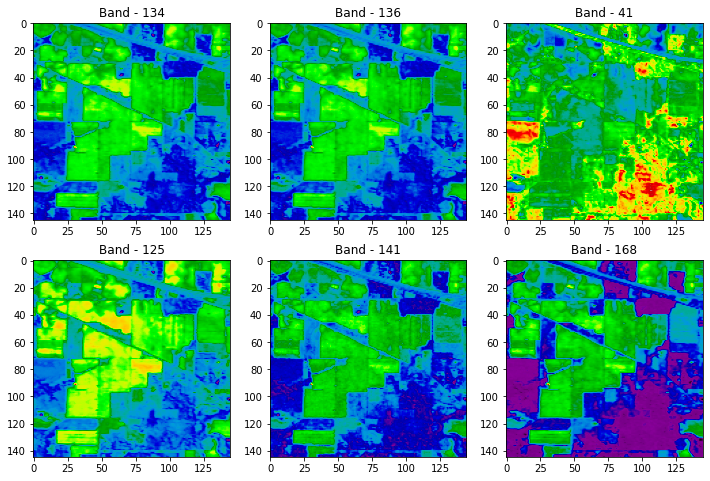

In [5]:
fig = plt.figure(figsize = (12, 8))
# plt.title('randomly selected HSI')
for i in range(1, 7):
    fig.add_subplot(2,3, i)
    band = np.random.randint(X.shape[2])
    plt.imshow(X[:,:,band], cmap='nipy_spectral')
    plt.title(f'Band - {band}')


ImageView object:
  Interpolation       :  <default>

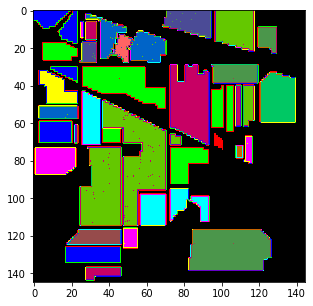

In [6]:
# plt.colorbar()
spectral.imshow(classes=Y.astype(int),figsize =(5,5))


In [7]:
print("Shape of X",X.shape,"Shape of Y",Y.shape)

Shape of X (145, 145, 200) Shape of Y (145, 145)


spectral:INFO: Setting min samples to 200
spectral:WARNING: Omitting class   1 : only 46 samples present
spectral:WARNING: Omitting class   7 : only 28 samples present
spectral:WARNING: Omitting class   9 : only 20 samples present
spectral:WARNING: Omitting class  16 : only 93 samples present


Processing...  0.0%Processing...  8.3%Processing... 16.7%Processing... 25.0%Processing... 33.3%Processing... 41.7%Processing... 50.0%Processing... 58.3%Processing... 66.7%Processing... 75.0%Processing... 83.3%Processing... 91.7%Processing... 100.0%Processing...done   


ImageView object:
  Interpolation       :  <default>

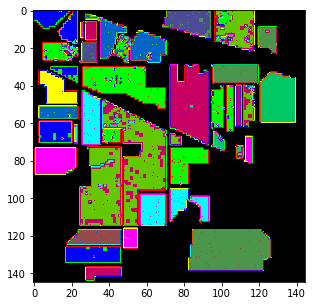

In [8]:
classes=create_training_classes(X,Y)
gmlc=GaussianClassifier(classes)
output=gmlc.classify_image(X)
results=output*(Y!=0)
spectral.imshow(classes=results.astype(int),figsize =(5,5))

ImageView object:
  Interpolation       :  <default>

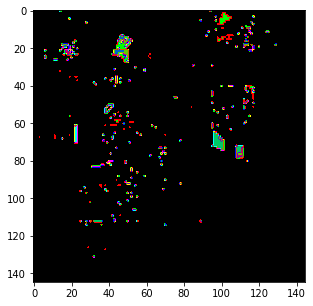

In [9]:
error=results*(results!=Y)
spectral.imshow(classes=error.astype(int),figsize =(5,5))

In [10]:
print(results.shape,output.shape)

(145, 145) (145, 145)


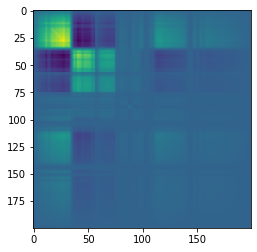

In [6]:
pc = principal_components(X)

v = imshow(pc.cov)
# In the covariance matrix display, whiter values indicate strong positive covariance, darker values indicate strong negative covariance, and grey values indicate covariance near zero.
# To reduce dimensionality using principal components, we can sort the eigenvalues in descending order and then retain enough eigenvalues (an corresponding eigenvectors) to capture a 
# desired fraction of the total image variance. We then reduce the dimensionality of the image pixels by projecting them onto the remaining eigenvectors. We will choose to retain a minimum of 
# 99.9% of the total image variance.

In [7]:
pc_0989 = pc.reduce(fraction=0.989)
# How many eigenvalues are left?
len(pc_0989.eigenvalues)

24

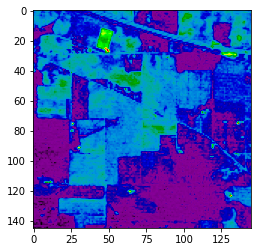

In [8]:
plt.imshow(X[:,:,4], cmap='nipy_spectral')

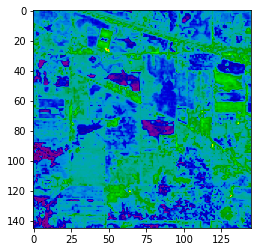

In [9]:
img_pc = pc_0989.transform(X)
plt.imshow(img_pc[:,:,4], cmap='nipy_spectral')
# v = imshow(img_pc[:,:,:4])

In [10]:
img_pc.shape

(145, 145, 24)

spectral:INFO: Setting min samples to 24
spectral:WARNING: Omitting class   9 : only 20 samples present


Processing...  0.0%Processing...  6.7%Processing... 13.3%Processing... 20.0%Processing... 26.7%Processing... 33.3%Processing... 40.0%Processing... 46.7%Processing... 53.3%Processing... 60.0%Processing... 66.7%Processing... 73.3%Processing... 80.0%Processing... 86.7%Processing... 93.3%Processing... 100.0%Processing...done   


ImageView object:
  Interpolation       :  <default>

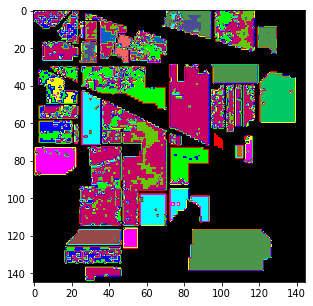

In [11]:
classes=create_training_classes(img_pc,Y)
gmlc=GaussianClassifier(classes)
output=gmlc.classify_image(img_pc)
results=output*(Y!=0)
spectral.imshow(classes=results.astype(int),figsize =(5,5))


ImageView object:
  Interpolation       :  <default>

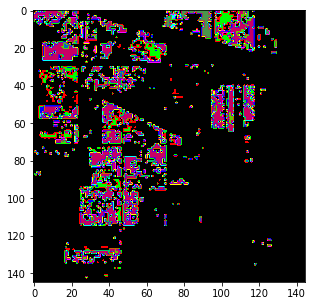

In [12]:
error=results*(results!=Y)
spectral.imshow(classes=error.astype(int),figsize =(5,5))

In [13]:
img_pc.shape

(145, 145, 24)

In [14]:
def padding_with_zeros(X, margin=2):
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return newX

In [15]:
def imagewindows(X, y, windowSize=5, removeZeroLabels = True):
    margin = int((windowSize - 1) / 2)
    zeroPaddedX = padding_with_zeros(X, margin=margin)
    # split patches
    patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]))
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]   
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
        patchesLabels -= 1
    return patchesData, patchesLabels

In [16]:
X_win, y = imagewindows(img_pc, Y, windowSize=25)
X_win.shape, y.shape

((10249, 25, 25, 24), (10249,))

In [17]:
X_train,X_test,y_train,y_test=train_test_split(X_win,y,test_size=.50,random_state=42)

In [18]:
X_train.shape

(5124, 25, 25, 24)

In [19]:
X_train = X_train.reshape(-1, 25, 25, 24, 1)
X_train.shape

(5124, 25, 25, 24, 1)

In [20]:
y_train = np_utils.to_categorical(y_train)
y_train.shape

(5124, 16)

In [21]:
model = tf.keras.models.Sequential([
        keras.layers.Conv3D(16,(3,3,3),input_shape=(25, 25, 24, 1)),
        keras.layers.Conv3D(32,(3,3,5)),
        # keras.layers.MaxPooling3D(),  
        
    
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256,activation='relu'),
        tf.keras.layers.Dropout(.5),
        tf.keras.layers.Dense(512,activation='relu'),
        tf.keras.layers.Dropout(.5),
        tf.keras.layers.Dense(16,activation='softmax')
    
])

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 23, 23, 22, 16)    448       
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 21, 21, 18, 32)    23072     
_________________________________________________________________
flatten (Flatten)            (None, 254016)            0         
_________________________________________________________________
dense (Dense)                (None, 256)               65028352  
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               131584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0

In [23]:
adam = Adam(lr=0.001)
model.compile(loss='categorical_crossentropy',optimizer=adam,metrics=['accuracy'])

In [24]:
class myCallback(tf.keras.callbacks.Callback):
        def on_epoch_end(self,epoch,logs={}):
            if logs.get('accuracy')>0.99:
                print('Reached 99% accuracy so cancelling training!')
                self.model.stop_training=True

In [25]:
callbacks=myCallback()
from IPython.display import display
from PIL import Image


history = model.fit(X_train,y_train,
                    epochs=50,
                    steps_per_epoch=200,
                    callbacks=[callbacks]
                   )

Epoch 1/50
200/200 [==============================] - 39s 33ms/step - loss: 1186.7807 - accuracy: 0.4653
Epoch 2/50
200/200 [==============================] - 6s 32ms/step - loss: 152.4920 - accuracy: 0.8296
Epoch 3/50
200/200 [==============================] - 6s 32ms/step - loss: 70.7542 - accuracy: 0.8994
Epoch 4/50
200/200 [==============================] - 6s 32ms/step - loss: 63.2990 - accuracy: 0.9280
Epoch 5/50
200/200 [==============================] - 6s 32ms/step - loss: 62.2519 - accuracy: 0.9387
Epoch 6/50
200/200 [==============================] - 6s 32ms/step - loss: 71.5686 - accuracy: 0.9388
Epoch 7/50
200/200 [==============================] - 7s 33ms/step - loss: 194.1913 - accuracy: 0.9074
Epoch 8/50
200/200 [==============================] - 7s 33ms/step - loss: 217.2853 - accuracy: 0.9236
Epoch 9/50
200/200 [==============================] - 7s 33ms/step - loss: 196.7749 - accuracy: 0.9353
Epoch 10/50
200/200 [==============================] - 7s 33ms/step - loss:

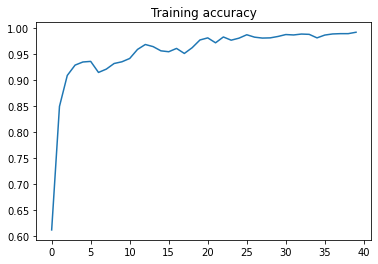

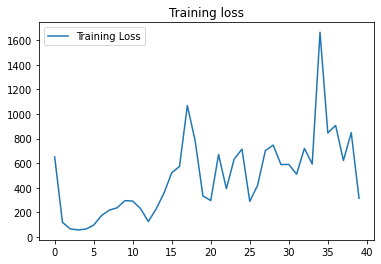

In [26]:
acc = history.history['accuracy']
loss = history.history['loss']
epochs = range(len(acc))
plt.plot(epochs, acc, label='Training accuracy')
plt.title('Training accuracy')
plt.figure()
plt.plot(epochs, loss,label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()

In [27]:
model.save('/content/drive/MyDrive/ANN project/indiana_pines_model_2.h5')

In [28]:
X_test_reshaped = X_test.reshape(-1, 25, 25, 24, 1)
X_test_reshaped.shape

(5125, 25, 25, 24, 1)

In [29]:
y_test_reshaped = np_utils.to_categorical(y_test )
y_test_reshaped.shape

(5125, 16)

In [130]:
Y_pred_test = model.predict(X_test_reshaped)
y_pred_test = np.argmax(Y_pred_test, axis=1)
y_test_uncategorical=np.argmax(y_test_reshaped, axis=1)
classification = classification_report(y_test_uncategorical, y_pred_test)
print(classification)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        29
           1       1.00      1.00      1.00       700
           2       1.00      0.99      0.99       415
           3       1.00      1.00      1.00       108
           4       1.00      1.00      1.00       240
           5       1.00      1.00      1.00       367
           6       1.00      1.00      1.00        15
           7       1.00      1.00      1.00       238
           8       1.00      1.00      1.00         8
           9       1.00      0.99      1.00       494
          10       1.00      1.00      1.00      1200
          11       1.00      1.00      1.00       308
          12       1.00      1.00      1.00        97
          13       1.00      1.00      1.00       634
          14       1.00      1.00      1.00       225
          15       0.98      1.00      0.99        47

    accuracy                           1.00      5125
   macro avg       1.00   